# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import torch

D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

In [34]:
X = (X - X.mean(axis=0))/(X.std(axis = 0) + 1e-12)
Y = Y.reshape((-1,1))

X = torch.tensor(X, dtype=torch.float)
Y = torch.tensor(Y, dtype=torch.float)

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [35]:
class LinearModel(torch.nn.Module):
    def __init__(self, in_features):
        super(LinearModel,self).__init__()
        self.fc = torch.nn.Linear(in_features, 1, bias=True)
        
    def forward(self,x):
        x = self.fc(x)
        return x

In [36]:
batch_size = 16

In [51]:
def train_model(model, criterion, optimizer, X_train, y_train, X_val=None, y_val=None, epochs = 500):
    history, val_history = [], []
    
    for epoch in range(1, epochs + 1):
        fraction = X_train.shape[0] // batch_size
        batch_range = range(fraction)
        
        for i in batch_range:
            x_batch = X_train[i * batch_size: (i + 1) * batch_size]
            y_batch = y_train[i * batch_size: (i + 1) * batch_size]
            
            optimizer.zero_grad()
            predictions = model(x_batch)
            
            loss = criterion(y_batch, predictions)
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
        with torch.no_grad():
            history.append(loss.item())
            if (X_val is not None) or (y_val is not None):
                val_predictions = model(X_val)
                val_history.append(criterion(val_predictions, y_val).item())
                
    return history, val_history

### 1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования.

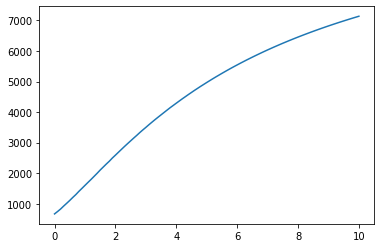

In [38]:
param_range = np.arange(0.0, 10.1, 0.1)
loss_list = []

for alpha in param_range:
    
    history, val_history = train_model(model, mse_loss, optimizer, X, Y, epochs = 100)
    model.eval()
    prediction = model(X)
    loss = mse_loss(prediction, Y)
    loss_list.append(loss.item())

plt.plot(param_range, loss_list)


### 2. Подготовьте исходные данные для 5 fold CV.

In [39]:
def k_fold_training(X, y, k, epochs, lr, weight_decay_param):
    num_val_samples = len(X) // k
    
    models = []
    history_list = []
    train_scores = []
    val_scores = []
    
    for i in range(k):
        val_data = X[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = Y[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = torch.Tensor(np.concatenate([X[:i * num_val_samples], X[(i + 1) * num_val_samples:]], axis=0))
        partial_train_targets = torch.Tensor(np.concatenate([y[:i * num_val_samples], y[(i + 1) * num_val_samples:]], axis=0))
        model = LinearModel(X.shape[1])
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay = weight_decay_param)
        
        history = train_model(model, criterion, optimizer, partial_train_data, partial_train_targets, val_data, val_targets, epochs = epochs)
        
        with torch.no_grad():
            val_score = criterion(model(val_data), val_targets)
            train_score = criterion(model(partial_train_data), partial_train_targets)
        
        models.append(model)
        train_scores.append(train_score)
        val_scores.append(val_score)        
        history_list.append(history)
    
    return {'models': models, 'history': history_list, 'train_scores': train_scores, 'val_scores': val_scores}
    

In [41]:
info = k_fold_training(X,Y, 5, 50, 0.1, weight_decay_param=0.1)

### 3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.

In [45]:
def random_search(X, y , steps, lr, weight_decay_param, epochs = 100):
    mean_scores = []
    params_list = []
    for i in range(1, steps+1):
        random_lr = np.random.uniform(*lr)
        random_weigh_decay = np.random.uniform(*weight_decay_param)
        params = {'lr': random_lr, 'weight_decay': random_weigh_decay}
        
        info = k_fold_training(X, y, 5, epochs, random_lr, random_weigh_decay)
        mean_score = np.array(info['val_scores']).mean()
        
        mean_scores.append(mean_score)
        params_list.append(params)
    
    min_index = np.array(mean_scores).argmin()
    return params_list[min_index]
        

In [46]:
params_list = random_search(X, Y, 10, [1e-5, 1e-1], [0.0, 1.0])

### 4. Постройте валидационную кривую. 


In [47]:
model = LinearModel(X.shape[1])
mse_loss = torch.nn.MSELoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), **params_list)

history, val_history = train_model(model, mse_loss, optimizer, X[200:], Y[200:], X[:200], Y[:200], epochs = 10)

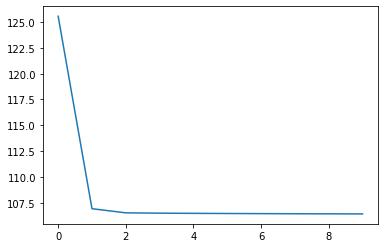

In [48]:
plt.plot(range(len(val_history)), val_history)

### 5. Постройте кривую обучения.


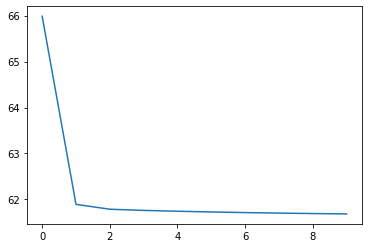

In [49]:
plt.plot(range(len(history)), history)

